In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import seaborn as sns
from scipy.io import readsav
from scipy import integrate
from scipy.signal import convolve2d

sns.set_style('darkgrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

data = readsav('aztec_sim_data.sav')
print(np.shape(data.coadded_signal_map))
print(data.keys())
print(np.shape(data.phys_dec_map))
Y, X = np.meshgrid(data.phys_dec_map,data.phys_ra_map)
print(np.shape(data.kernel_mean))
print(np.unravel_index(data.kernel_mean.argmax(), data.kernel_mean.shape))
print(np.mean(np.diff(data.phys_dec_map)))

(1436, 1811)
dict_keys(['kernel_mean', 'coadded_weight_map', 'phys_dec_map', 'coadded_signal_map', 'phys_ra_map'])
(1436,)
(1436, 1810)
(718, 905)
0.0005555555555555558


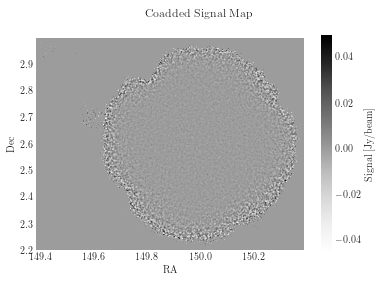

In [2]:
plt.pcolormesh(X, Y, data.coadded_signal_map.T, cmap='Greys')
# plt.xlim(149.75, 150.25)
# plt.ylim(2.35, 2.85)
plt.gca().set_aspect('equal')
plt.suptitle('Coadded Signal Map')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Signal [Jy/beam]')
plt.show()

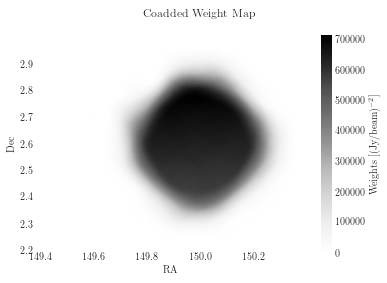

In [3]:
plt.pcolormesh(X, Y, data.coadded_weight_map.T, cmap='Greys')
# plt.xlim(149.75, 150.25)
# plt.ylim(2.35, 2.85)
plt.gca().set_aspect('equal')
plt.suptitle('Coadded Weight Map')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Weights [(Jy/beam)$^{-2}$]')
plt.show()

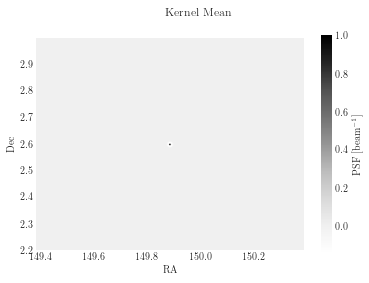

In [4]:
plt.pcolormesh(X, Y, data.kernel_mean.T, cmap='Greys')
# plt.xlim(149.75, 150.25)
# plt.ylim(2.35, 2.85)
plt.gca().set_aspect('equal')
plt.suptitle('Kernel Mean')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='PSF [beam$^{-1}$]')
plt.show()

In [5]:
masked_weights = ma.masked_less(data.coadded_weight_map[:, :-1], 0.0014**(-2.0))
masked_signal = ma.masked_array(data.coadded_signal_map[:, :-1], mask=masked_weights.mask)
masked_kernel_map = ma.masked_array(data.kernel_mean, mask=masked_weights.mask)
sn_map = masked_signal*np.sqrt(masked_weights)
sn_map[np.where(sn_map < 0.0)] = 0.0
hist_signal = masked_signal.compressed()

def make_gaussian(x_array, mean, amp, width, bg):
    return bg + amp*np.exp((-(x_array - mean)**2.0)/(2.0*(width**2.0)))

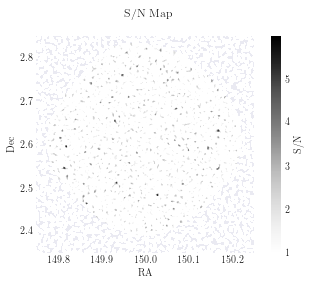

In [6]:
plt.pcolormesh(X, Y, sn_map.T, cmap='Greys', vmin=1.0, vmax=np.max(sn_map))
plt.suptitle('S/N Map')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='S/N')
plt.xlim(149.75, 150.25)
plt.ylim(2.35, 2.85)
plt.gca().set_aspect('equal')
plt.show()

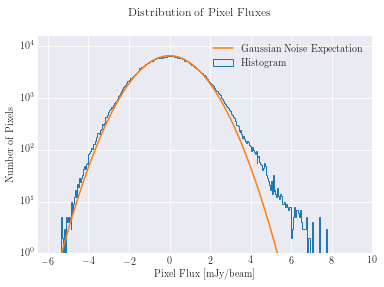

In [7]:
n, bins, _ = plt.hist(hist_signal*1000.0, bins='auto', histtype='step', label='Histogram')
plt.gca().set_yscale('log')
plt.plot(bins,
         make_gaussian(bins,
                       0.0,
                       np.max(n),
                       1000.0/np.mean(np.sqrt(masked_weights.compressed())),
                       0.0),
        label='Gaussian Noise Expectation')
plt.suptitle('Distribution of Pixel Fluxes')
plt.xlabel('Pixel Flux [mJy/beam]')
plt.ylabel('Number of Pixels')
plt.xlim(-6.5, 10.0)
plt.ylim(1.0, 10.0**(1.1*np.log10(np.max(n))))
plt.legend()
plt.show()

In [8]:
sn_cut = ma.masked_outside(sn_map, 3.9, 4.1)
signal_cut = ma.masked_array(masked_signal, mask=sn_cut.mask)
mean_s = signal_cut.mean()*1000.0
noise_s = signal_cut.std()*1000.0
print(mean_s, noise_s)

5.044118662759214 0.16762160149702435


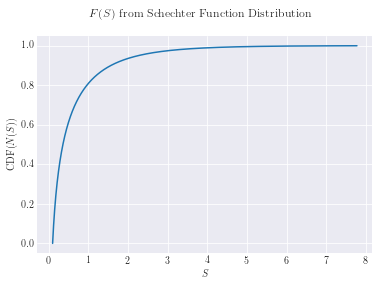

In [9]:
def get_dN_ds_arr(s_min, s_max, n_points,
                  n_prime=3200.0, s_prime=1.6,
                  alpha=-2.0):
    s_array = np.linspace(s_min, s_max, n_points)
    alpha_factor = (s_array/s_prime)**(alpha + 1.0)
    exp_factor = np.exp(-s_array/s_prime)
    return n_prime*alpha_factor*exp_factor, s_array

def get_Ns_arr(dN_ds_arr, s_arr):
    Ns_arr = integrate.cumtrapz(dN_ds_arr, s_arr, initial=0.0)
    return Ns_arr

def get_random_S(s_arr, Ns_arr):
    rand_value = np.random.uniform()
    max_s = np.interp(rand_value,
                      s_arr, Ns_arr/Ns_arr[-1])
    exp_Ns = Ns_arr[np.where(s_arr >= max_s)][0]
    return rand_value, exp_Ns, max_s
def get_poisson_Ns(exp_Ns):
    return np.random.poisson(exp_Ns)

def assign_fluxes(s_arr, Ns_arr, rand_value, poisson_Ns):
    rand_arr = np.random.uniform(size=poisson_Ns)
    return np.interp(rand_arr, s_arr, Ns_arr/Ns_arr[-1])

def assign_pixels(zero_map, fluxes):
    old_shape = np.shape(zero_map)
    flat_map = zero_map.flatten()
    idx = np.random.choice(flat_map.size, size=len(fluxes))
    flat_map[idx] = fluxes
    return flat_map.reshape(old_shape)

def make_map(s_arr, Ns_arr):
    zero_map = np.zeros((500, 500))
    rand_value, exp_Ns, max_s = get_random_S(s_arr, Ns_arr)
    poisson_Ns = get_poisson_Ns(exp_Ns)
    fluxes = assign_fluxes(s_arr, Ns_arr, rand_value, poisson_Ns)
    new_map = assign_pixels(zero_map, fluxes)
    return convolve2d(new_map,
                      data.kernel_mean[668:768, 855:955],
                      mode='same')

def make_histogram_mean(s_arr, Ns_arr, n_samples=100):
    first_map = make_map(s_arr, Ns_arr)
    fill_array = np.empty((n_samples,
                           np.shape(first_map)[0],
                           np.shape(first_map)[1]))
    fill_array[0, :, :] = first_map
    for i in range(1, n_samples):
        fill_array[i, :, :] = make_map(s_arr, Ns_arr)
    return fill_array.flatten()

dN_ds_arr, s_arr = get_dN_ds_arr(0.1,
                                 np.max(hist_signal)*1000.0,
                                 30000)
Ns_arr = get_Ns_arr(dN_ds_arr, s_arr)

plt.plot(s_arr, Ns_arr/Ns_arr[-1])
plt.xlabel(r'$S$')
plt.ylabel(r'CDF$\left(N(S)\right)$')
plt.suptitle('$F(S)$ from Schechter Function Distribution')
plt.show()

In [10]:
test_map = make_map(s_arr, Ns_arr)

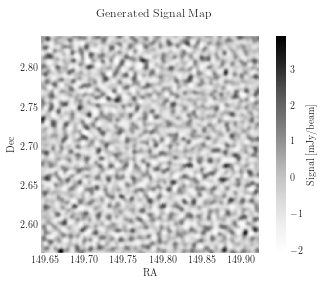

In [11]:
plt.pcolormesh(X[468:968, 655:1155],
               Y[468:968, 655:1155],
               test_map.T, cmap='Greys')
# plt.xlim(149.75, 150.25)
# plt.ylim(2.35, 2.85)
plt.gca().set_aspect('equal')
plt.suptitle('Generated Signal Map')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Signal [mJy/beam]')
plt.show()

In [12]:
fill_array = make_histogram_mean(s_arr, Ns_arr)

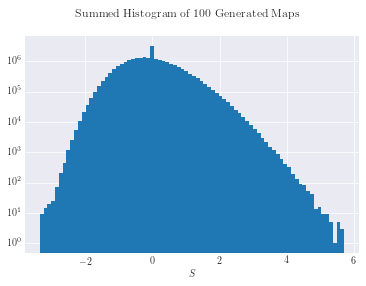

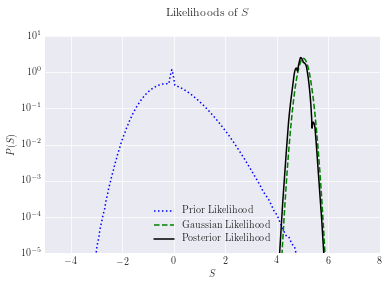

In [13]:
n, bins, _ = plt.hist(fill_array, bins=80)
plt.xlabel('$S$')
plt.suptitle('Summed Histogram of 100 Generated Maps')
plt.gca().set_yscale('log')
plt.show()

prob_s = np.linspace(-5.0, 8.0, 100000)
prior_y = n
prior_x = bins[:-1]
prob_prior = np.interp(prob_s, prior_x, prior_y)
prob_prior = prob_prior/np.trapz(prob_prior, prob_s)

gauss_y = make_gaussian(prob_s, mean_s, 1.0, noise_s, 0.0)
gauss_y = gauss_y/np.trapz(gauss_y, prob_s)

posterior = prob_prior*gauss_y
posterior = posterior/np.trapz(posterior, prob_s)

plt.plot(prob_s, prob_prior,linestyle=':',
         label='Prior Likelihood', color='b')

plt.plot(prob_s, gauss_y, linestyle='--',
        label='Gaussian Likelihood', color='g')
plt.plot(prob_s, posterior, linestyle='-',
       label='Posterior Likelihood', color='k')
plt.xlabel('$S$')
plt.ylabel('$P(S)$')
plt.legend()
plt.gca().set_yscale('log')
plt.ylim(10.0**(-5), 10.0)
plt.xlim(-5.0, 8.0)
plt.suptitle("Likelihoods of $S$")
plt.show()

In [14]:
print(prob_s[np.where(posterior >= np.mean(posterior))][0])

4.499714997149971


The de-boosted flux estimate is 4.5 mJy, slightly lower than the naive estimate which gave 5.04 mJy. A flux-limited survey would mischaracterize the occurrence rate and completeness of high SNR detections if it used the higher estimate flux instead.